# Logistic Regression

Ada berbagai paket Go yang ada yang menerapkan regresi logistik, termasuk github.com/xlvector/hector, github.com/cdipaolo/goml, dan github.com/sjwhitworth/golearn. Namun, dalam contoh ini, kita akan menerapkan regresi logistik dari awal, sehingga kita dapat membentuk pemahaman penuh tentang apa yang diperlukan untuk melatih model dan memahami kesederhanaan regresi logistik. Selain itu, dalam beberapa kasus, Kita mungkin ingin menggunakan implementasi from-scratch untuk menghindari dependensi tambahan dalam basis kode kita.

Logistic Regression mengacu pada rumus fungsi logistik, yaitu: f(x) = 1/(1 + e^-x). Fungsi di atas dapat diimplmentasikan di golang menjadi :

In [19]:
func logistic(x float64) float64 { 
    return 1 / (1 + math.Exp(-x)) 
}

Untuk lebih jelas, kita bisa membuat plot fungsi logistik di atas.

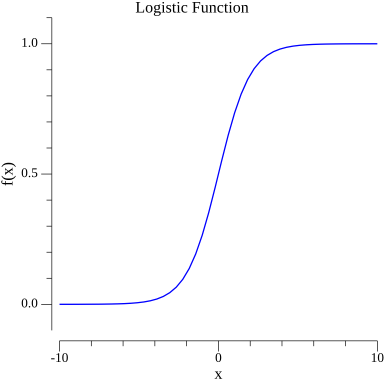

In [20]:
import ( 
    "gonum.org/v1/plot" 
    "gonum.org/v1/plot/plotter" 
    "github.com/janpfeifer/gonb/gonbui"
)

%%
// Create a new plot.
p := plot.New()
p.Title.Text = "Logistic Function"
p.X.Label.Text = "x"
p.Y.Label.Text = "f(x)"

// Create the plotter function.
logisticPlotter := plotter.NewFunction(func(x float64) float64 { return logistic(x) })
logisticPlotter.Color = color.RGBA{B: 255, A: 255}

// Add the plotter function to the plot.
p.Add(logisticPlotter)

// Set the axis ranges. Unlike other data sets,
// functions don't set the axis ranges automatically
// since functions don't necessarily have a
// finite range of x and y values.
p.X.Min = -10
p.X.Max = 10
p.Y.Min = -0.1
p.Y.Max = 1.1

buf := bytes.NewBuffer(nil)
writerTo, err := p.WriterTo(4*vg.Inch, 4*vg.Inch, "png")
if err != nil {
    panic(err)
}
writerTo.WriteTo(buf)
gonbui.DisplayPng(buf.Bytes())

## Regresi Logistik untuk Peminjaman 

Kita akan menerapkan regresi logistik untuk dataset loan.csv

In [21]:
import "github.com/go-gota/gota/dataframe"

In [22]:
func getDataframe(file string) (dataframe.DataFrame, error) {
    var df dataframe.DataFrame 
    f, err := os.Open(file)
    if err != nil {
        return df, err
    }
    defer f.Close()

    return dataframe.ReadCSV(f), nil
}

In [23]:
%%
df, err := getDataframe("../data/loan.csv")
if err != nil {
    fmt.Println(err)
    return
}

fmt.Println(df)

[2500x2] DataFrame

    FICO.Range Interest.Rate
 0: 735-739    8.90%
 1: 715-719    12.12%
 2: 690-694    21.98%
 3: 695-699    9.99%
 4: 695-699    11.71%
 5: 670-674    15.31%
 6: 720-724    7.90%
 7: 705-709    17.14%
 8: 685-689    14.33%
 9: 715-719    6.91%
    ...        ...
    <string>   <string>



## Profiling Data

Ada fitur FICO.Range dan Interest.Rate, kita akan membuat suatu model logistic regression yang mendapat fitur skor kredit, dan menghasikkan output berupa klasifikasi apakah skor kredit tersebut layak mendapatkan bunga di bawah 12% atau tidak. Untuk itu kita akan melakukan pemrosesan data dengan cara: 

1. Manipulasi Field FICO.Range 
* Ambil nilai minimum dari FICO.Range
* Normalisasi score FICO dengan teknik Min-Max Scaling. Rumus : x' = (x - min) / (max - min). Dalam hal ini nilai maksimum adalah 830 dan nilai minimum adalah 640. Dengan normalisasi ini maka nilai skor FICO akan berada dalam rentang 0 sampai 1.

2. Manipulasi Interest.Rate
* Hapus string "%" dan ubah value menjadi float.
* Buat label class, jika Interest.Rate <= 12 diisi denhgan 1.0 (true). JIka Interest.Rate > 12 diisi dengan 0.0 (false).

Hasil dari pemrosesan data disimpan dalam clean_loan.csv

In [1]:
%%
// Open the loan dataset file.
f, err := os.Open("../data/loan.csv")
if err != nil {
    log.Fatal(err)
}
defer f.Close()

// Create a new CSV reader reading from the opened file.
reader := csv.NewReader(f)
reader.FieldsPerRecord = 2

// Read in all of the CSV records
rawCSVData, err := reader.ReadAll()
if err != nil {
    log.Fatal(err)
}

// Create the output file.
f, err = os.Create("clean_loan.csv")
if err != nil {
    log.Fatal(err)
}
defer f.Close()

// Create a CSV writer.
w := csv.NewWriter(f)

// Sequentially move the rows writing out the parsed values.
for idx, record := range rawCSVData {

    // Skip the header row.
    if idx == 0 {

        // Write the header to the output file.
        if err := w.Write([]string{"FICO_score", "class"}); err != nil {
            log.Fatal(err)
        }
        continue
    }

    // Initialize a slice to hold our parsed values.
    outRecord := make([]string, 2)

    // Parse and normalize the FICO score.
    score, err := strconv.ParseFloat(strings.Split(record[0], "-")[0], 64)
    if err != nil {
        log.Fatal(err)
    }

    outRecord[0] = strconv.FormatFloat((score-640.0)/(830.0-640.0), 'f', 4, 64)

    // Parse the Interest rate class.
    rate, err := strconv.ParseFloat(strings.TrimSuffix(record[1], "%"), 64)
    if err != nil {
        log.Fatal(err)
    }

    if rate <= 12.0 {
        outRecord[1] = "1.0"

        // Write the record to the output file.
        if err := w.Write(outRecord); err != nil {
            log.Fatal(err)
        }
        continue
    }

    outRecord[1] = "0.0"

    // Write the record to the output file.
    if err := w.Write(outRecord); err != nil {
        log.Fatal(err)
    }
}

// Write any buffered data to the underlying writer (standard output).
w.Flush()

if err := w.Error(); err != nil {
    log.Fatal(err)
}

In [25]:
func createPlot(data []float64, name string, plotType string) []byte {
    v := make(plotter.Values, len(data)) 
    for i, floatVal := range data { 
        v[i] = floatVal 
    }
    
    p := plot.New() 
    p.Title.Text = fmt.Sprintf("%s of a %s", plotType, name) 
    
    switch plotType {
	case "Box Plot":
		b, err := plotter.NewBoxPlot(vg.Points(50), 0, v) 
        if err != nil { 
            log.Fatal(err) 
        }
        p.Add(b)
	default:
		h, err := plotter.NewHist(v, 16) 
        if err != nil { 
            log.Fatal(err) 
        }
        h.Normalize(1) 
        p.Add(h)
	}
    
    
    buf := bytes.NewBuffer(nil)
    writerTo, err := p.WriterTo(4*vg.Inch, 4*vg.Inch, "png")
    if err != nil {
        panic(err)
    }
    writerTo.WriteTo(buf)
    return buf.Bytes()
}


In [7]:
func display(df dataframe.DataFrame, col string, plotType string) {
    data := df.Col(col).Float() 
    gonbui.DisplayPng(createPlot(data, col, plotType))
}

[8x3] DataFrame

    column   FICO_score class
 0: mean     0.346782   0.396800
 1: median   0.315800   0.000000
 2: stddev   0.184383   0.489332
 3: min      0.000000   0.000000
 4: 25%      0.210500   0.000000
 5: 50%      0.315800   0.000000
 6: 75%      0.447400   1.000000
 7: max      1.000000   1.000000
    <string> <float>    <float>



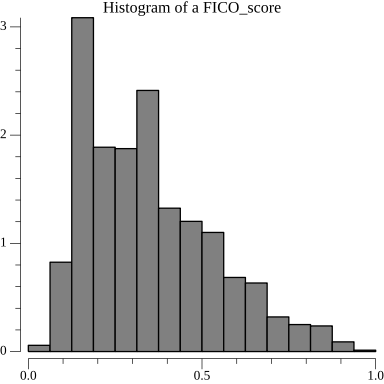

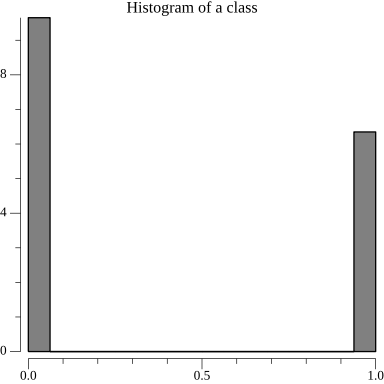

In [26]:
%%
df, err := getDataframe("clean_loan.csv")
if err != nil {
    fmt.Println(err)
    return
}

fmt.Println(df.Describe())

for _, col := range df.Names() {
    display(df, col, "Histogram")
}

## Membagi Data menjadi Training dan Test Set

Untuk menghindari overfitting dan memastikan model kita dapat digeneralisasi, kita akan membagi dataset kita menjadi training set dan test set. Kita akan menggunakan library untuk membuat training set dan test set, lalu menyimpannya ke file .csv masing-masing. Dalam kasus ini, kita akan menggunakan pembagian 80/20 untuk data training dan test kita.

In [2]:
%%
// Open the clean loan dataset file.
f, err := os.Open("clean_loan.csv")
if err != nil {
    log.Fatal(err)
}
defer f.Close()

// Create a dataframe from the CSV file.
// The types of the columns will be inferred.
loanDF := dataframe.ReadCSV(f)

// Calculate the number of elements in each set.
trainingNum := (4 * loanDF.Nrow()) / 5
testNum := loanDF.Nrow() / 5
if trainingNum+testNum < loanDF.Nrow() {
    trainingNum++
}

// Create the subset indices.
trainingIdx := make([]int, trainingNum)
testIdx := make([]int, testNum)

// Enumerate the training indices.
for i := 0; i < trainingNum; i++ {
    trainingIdx[i] = i
}

// Enumerate the test indices.
for i := 0; i < testNum; i++ {
    testIdx[i] = trainingNum + i
}

// Create the subset dataframes.
trainingDF := loanDF.Subset(trainingIdx)
testDF := loanDF.Subset(testIdx)

// Create a map that will be used in writing the data
// to files.
setMap := map[int]dataframe.DataFrame{
    0: trainingDF,
    1: testDF,
}

// Create the respective files.
for idx, setName := range []string{"training.csv", "test.csv"} {

    // Save the filtered dataset file.
    f, err := os.Create(setName)
    if err != nil {
        log.Fatal(err)
    }

    // Create a buffered writer.
    w := bufio.NewWriter(f)

    // Write the dataframe out as a CSV.
    if err := setMap[idx].WriteCSV(w); err != nil {
        log.Fatal(err)
    }
}

## Melatih dan Menguji Model Regresi Logistik

Sekarang, mari kita buat fungsi yang melatih model regresi logistik. Fungsi ini perlu melakukan hal berikut:

* Terima data fitur sebagai variabel independen.
* Tambahkan intersepsi ke model kita.
* Inisialisasi dan optimalkan koefisien (atau bobot) dari model regresi logistik.
* Kembalikan bobot teroptimalkan yang menentukan model terlatih kita.

Untuk mengoptimalkan koefisien/bobot, kita akan menggunakan teknik yang disebut gradient descent stokastik. Teknik ini tidak dibahas lebih lanjut, cukup dikatakan bahwa kita mencoba membuat prediksi dengan beberapa bobot yang tidak dioptimalkan, menghitung kesalahan untuk bobot tersebut, dan kemudian memperbaruinya secara iteratif untuk memaksimalkan kemungkinan membuat prediksi yang benar.

Implementasi optimisasi ini adalah sebagai berikut. Fungsi tersebut mengambil berikutnya sebagai input:

* features: Pointer ke matriks gonum mat64.Dense. Matriks ini mencakup kolom untuk setiap variabel independen yang kita gunakan bersama dengan kolom 1.0s yang mewakili intersepsi.
* labels: Irisan float yang mencakup semua label kelas yang sesuai dengan fitur kita.
* numSteps: Jumlah iterasi maksimum untuk optimisasi.
* learningRate: Parameter yang dapat disesuaikan yang membantu dengan konvergensi optimisasi.

Fungsi kemudian mengeluarkan bobot teroptimalkan untuk model regresi logistik:

In [33]:
func logisticRegression(features *mat64.Dense, labels []float64, numSteps int, learningRate float64) []float64 {

	// Initialize random weights.
	_, numWeights := features.Dims()
	weights := make([]float64, numWeights)

	s := rand.NewSource(time.Now().UnixNano())
	r := rand.New(s)

	for idx, _ := range weights {
		weights[idx] = r.Float64()
	}

	// Iteratively optimize the weights.
	for i := 0; i < numSteps; i++ {

		// Initialize a variable to accumulate error for this iteration.
		var sumError float64

		// Make predictions for each label and accumlate error.
		for idx, label := range labels {

			// Get the features corresponding to this label.
			featureRow := mat64.Row(nil, idx, features)

			// Calculate the error for this iteration's weights.
			pred := logistic(featureRow[0]*weights[0] + featureRow[1]*weights[1])
			predError := label - pred
			sumError += math.Pow(predError, 2)

			// Update the feature weights.
			for j := 0; j < len(featureRow); j++ {
				weights[j] += learningRate * predError * pred * (1 - pred) * featureRow[j]
			}
		}
	}

	return weights
}

In [34]:
%%
// Open the training dataset file.
f, err := os.Open("training.csv")
if err != nil {
    log.Fatal(err)
}
defer f.Close()

// Create a new CSV reader reading from the opened file.
reader := csv.NewReader(f)
reader.FieldsPerRecord = 2

// Read in all of the CSV records
rawCSVData, err := reader.ReadAll()
if err != nil {
    log.Fatal(err)
}

// featureData and labels will hold all the float values that
// will eventually be used in our training.
featureData := make([]float64, 2*(len(rawCSVData)-1))
labels := make([]float64, len(rawCSVData)-1)

// featureIndex will track the current index of the features
// matrix values.
var featureIndex int

// Sequentially move the rows into the slices of floats.
for idx, record := range rawCSVData {

    // Skip the header row.
    if idx == 0 {
        continue
    }

    // Add the FICO score feature.
    featureVal, err := strconv.ParseFloat(record[0], 64)
    if err != nil {
        log.Fatal(err)
    }

    featureData[featureIndex] = featureVal

    // Add an intercept.
    featureData[featureIndex+1] = 1.0

    // Increment our feature row.
    featureIndex += 2

    // Add the class label.
    labelVal, err := strconv.ParseFloat(record[1], 64)
    if err != nil {
        log.Fatal(err)
    }

    labels[idx-1] = labelVal
}

// Form a matrix from the features.
features := mat64.NewDense(len(rawCSVData)-1, 2, featureData)

// Train the logistic regression model.
weights := logisticRegression(features, labels, 1000, 0.3)

// Output the Logistic Regression model formula to stdout.
formula := "p = 1 / ( 1 + exp(- m1 * FICO.score - m2) )"
fmt.Printf("\n%s\n\nm1 = %0.2f\nm2 = %0.2f\n\n", formula, weights[0], weights[1])


p = 1 / ( 1 + exp(- m1 * FICO.score - m2) )

m1 = 13.65
m2 = -4.89



Kita bisa menggunakan formula ini untuk membuat prediksi.

In [35]:
func predict(score float64) float64 {

	// Calculate the predicted probability.
	p := 1 / (1 + math.Exp(-13.65*score+4.89))

	// Output the corresponding class.
	if p >= 0.5 {
		return 1.0
	}

	return 0.0
}

## Evaluasi

Akurasi, presisi, dan recall adalah metrik yang digunakan untuk mengevaluasi kinerja model klasifikasi. Berikut adalah penjelasannya:

* Akurasi adalah metrik yang paling umum digunakan untuk mengevaluasi model klasifikasi. Ini menunjukkan proporsi prediksi yang benar dari semua prediksi.
* Presisi menunjukkan seberapa akurat model dalam mengidentifikasi contoh positif. Ini dihitung sebagai rasio prediksi positif yang benar terhadap semua prediksi positif.
* Recall menunjukkan seberapa baik model dalam mengidentifikasi semua contoh positif. Ini dihitung sebagai rasio prediksi positif yang benar terhadap semua contoh positif yang sebenarnya.

Pada kasus penipuan kartu kredit, presisi lebih penting karena positif palsu (menandai transaksi sah sebagai penipuan) dapat mengganggu pelanggan. Namun dalam diagnosis kanker, recall lebih penting karena negatif palsu (melewatkan kanker) dapat membahayakan nyawa.

Berikut sumber bacaan berbahasa Indonesia yang cukup baik, "Memahami Akurasi, Presisi, Recall, dan Specificity" https://esairina.medium.com/memahami-confusion-matrix-accuracy-precision-recall-specificity-dan-f1-score-610d4f0db7cf

In [43]:
import "gonum.org/v1/gonum/mat"

func format(X mat.Matrix) {
 fa := mat.Formatted(X, mat.Prefix(""), mat.Squeeze())
 fmt.Printf("%v\n", fa)
}

In [49]:
%%
// Open the test examples.
f, err := os.Open("test.csv")
if err != nil {
    log.Fatal(err)
}
defer f.Close()

// Create a new CSV reader reading from the opened file.
reader := csv.NewReader(f)

// observed and predicted will hold the parsed observed and predicted values
// form the labeled data file.
var observed []float64
var predicted []float64

// line will track row numbers for logging.
line := 1

// Read in the records looking for unexpected types in the columns.
for {

    // Read in a row. Check if we are at the end of the file.
    record, err := reader.Read()
    if err == io.EOF {
        break
    }

    // Skip the header.
    if line == 1 {
        line++
        continue
    }

    // Read in the observed value.
    observedVal, err := strconv.ParseFloat(record[1], 64)
    if err != nil {
        log.Printf("Parsing line %d failed, unexpected type\n", line)
        continue
    }

    // Make the corresponding prediction.
    score, err := strconv.ParseFloat(record[0], 64)
    if err != nil {
        log.Printf("Parsing line %d failed, unexpected type\n", line)
        continue
    }

    predictedVal := predict(score)

    // Append the record to our slice, if it has the expected type.
    observed = append(observed, observedVal)
    predicted = append(predicted, predictedVal)
    line++
}

var truePos, trueNeg, falsePos, falseNeg int

// Accumulate the true positive/negative and false positive/negative count.
for idx, oVal := range observed {
  if oVal == 1 && predicted[idx] == 1 {
    truePos++
  } else if oVal == 0 && predicted[idx] == 0 {
    trueNeg++
  } else if oVal == 0 && predicted[idx] == 1 {
    falsePos++
  } else {
    falseNeg++
  }
}

cm := mat.NewDense(2, 2, []float64{
    float64(truePos), float64(falsePos), 
    float64(falseNeg), float64(trueNeg),
})
fmt.Println("\nConfusionMatrix : \n")
format(cm)


// Calculate precision, recall, and accuracy.
precision := float64(truePos) / (float64(truePos) + float64(falsePos))
recall := float64(truePos) / (float64(truePos) + float64(falseNeg))
accuracy := float64(truePos + trueNeg) / float64(len(observed))
specificity := float64(trueNeg) / (float64(trueNeg) + float64(falsePos))
f1score := 2 * (recall * precision/ (recall+precision))

// Output the Accuracy value to standard out. 
fmt.Printf("\nAkurasi = %0.2f\n", accuracy)
fmt.Printf("\nPresisi = %0.2f\n", precision)
fmt.Printf("\nRecall = %0.2f\n", recall)
fmt.Printf("\nSpecificity = %0.2f\n", specificity)
fmt.Printf("\nF1-Score = %0.2f\n\n", f1score)



ConfusionMatrix : 

⎡147   44⎤
⎣ 39  270⎦

Akurasi = 0.83

Presisi = 0.77

Recall = 0.79

Specificity = 0.86

F1-Score = 0.78



## Interpretasi atas Hasil Evaluasi

Berdasarkan hasil evaluasi di atas, model ini menghasilkan pengukuran yang lumayan baik.

* Akurasi : 83% artinya dari semua aplikasi kredit yang diajukan, hanya 83% yang diprediksi dengan benar oleh model. Ini berarti bahwa 17% prediksi model tidak akurat.
* Presisi : 77% artinya dari semua orang yang diprediksi oleh model akan mendapatkan persetujuan kredit, hanya 77% yang benar-benar mendapatkan persetujuan. Ini berarti bahwa 23% orang yang diprediksi akan mendapatkan persetujuan kredit sebenarnya ditolak.
* Recall : 79% artinya model berhasil mengidentifikasi 79% orang yang benar-benar akan mendapatkan persetujuan kredit. Ini berarti bahwa ada 21% orang yang seharusnya mendapatkan persetujuan kredit yang ditolak oleh model.

## Menggunakan goml untuk Logistic Regression

Seperti yang disebutkan di awal tulisan ini, ada banyak library di golang yang mengimplementasikan logictic regression. Menurut saya, yang paling populer adalah GoLearn dan goml. Kita akan menggunakan salah satunya, yaitu goml.

In [50]:
import (
    "github.com/cdipaolo/goml/base"
    "github.com/cdipaolo/goml/linear"
    "gonum.org/v1/plot" 
    "gonum.org/v1/plot/plotter" 
    "gonum.org/v1/plot/plotutil" 
    "github.com/janpfeifer/gonb/gonbui"
)    

In [51]:
type ConfusionMatrix struct {
	positive      int
	negative      int
	truePositive  int
	trueNegative  int
	falsePositive int
	falseNegative int
	recall        float64
	precision     float64
	accuracy      float64
}

In [52]:
func (cm ConfusionMatrix) String() string {
	return fmt.Sprintf("\tPositives: %d\n\tNegatives: %d\n\tTrue Positives: %d\n\tTrue Negatives: %d\n\tFalse Positives: %d\n\tFalse Negatives: %d\n\n\tRecall: %.2f\n\tPrecision: %.2f\n\tAccuracy: %.2f\n",
		cm.positive, cm.negative, cm.truePositive, cm.trueNegative, cm.falsePositive, cm.falseNegative, cm.recall, cm.precision, cm.accuracy)
}

In [53]:
func tryValues(learningRate float64, regularization float64, iterations int, decisionBoundary float64, xTrain, xTest [][]float64, yTrain, yTest []float64) (*ConfusionMatrix, *linear.Logistic, error) {
	cm := ConfusionMatrix{}
	for _, y := range yTest {
		if y == 1.0 {
			cm.positive++
		}
		if y == 0.0 {
			cm.negative++
		}
	}

	// Instantiate and Learn the Model
	model := linear.NewLogistic(base.BatchGA, learningRate, regularization, iterations, xTrain, yTrain)
	model.Output = ioutil.Discard
	err := model.Learn()
	if err != nil {
		return nil, nil, err
	}

	// Evaluate the Model on the Test data
	for i := range xTest {
		prediction, err := model.Predict(xTest[i])
		if err != nil {
			return nil, nil, err
		}
		y := int(yTest[i])
		positive := prediction[0] >= decisionBoundary

		if y == 1 && positive {
			cm.truePositive++
		}
		if y == 1 && !positive {
			cm.falseNegative++
		}
		if y == 0 && positive {
			cm.falsePositive++
		}
		if y == 0 && !positive {
			cm.trueNegative++
		}
	}

	// Calculate Evaluation Metrics
	cm.recall = float64(cm.truePositive) / float64(cm.positive)
	cm.precision = float64(cm.truePositive) / (float64(cm.truePositive) + float64(cm.falsePositive))
	cm.accuracy = float64(float64(cm.truePositive)+float64(cm.trueNegative)) / float64(float64(cm.positive)+float64(cm.negative))
	return &cm, model, nil
}

In [55]:
%%
xTrain, yTrain, err := base.LoadDataFromCSV("./training.csv")
if err != nil {
    fmt.Println(err)
    return 
}

xTest, yTest, err := base.LoadDataFromCSV("./test.csv")
if err != nil {
    fmt.Println(err)
    return
}

/*var maxAccuracy float64
var maxAccuracyCM *ConfusionMatrix
var maxAccuracyDb float64
var maxAccuracyIter int
var maxAccuracyModel *linear.Logistic

//Try different parameters to get the best model
for iter := 100; iter < 3000; iter += 500 {
    for db := 0.05; db < 1.0; db += 0.01 {
        cm, model, err := tryValues(0.0001, 0.0, iter, db, xTrain, xTest, yTrain, yTest)
        if err != nil {
            fmt.Println(err)
            return
        }
        if cm.accuracy > maxAccuracy {
            maxAccuracy = cm.accuracy
            maxAccuracyCM = cm
            maxAccuracyDb = db
            maxAccuracyModel = model
            maxAccuracyIter = iter
        }
    }
}

fmt.Printf("Maximum accuracy: %.2f\n\n", maxAccuracy)
fmt.Printf("with Model: %s\n\n", maxAccuracyModel)
fmt.Printf("with Confusion Matrix:\n%s\n\n", maxAccuracyCM)
fmt.Printf("with Decision Boundary: %.2f\n", maxAccuracyDb)
fmt.Printf("with Num Iterations: %d\n", maxAccuracyIter)
*/

db := float64(0.5)
cm, model, err := tryValues(0.0001, 0.0, 1000, db, xTrain, xTest, yTrain, yTest)
if err != nil {
    fmt.Println(err)
    return
}

fmt.Printf("with Model: %s\n\n", model)
fmt.Printf("with Confusion Matrix:\n%s\n\n", cm)

with Model: h(θ,x) = 1 / (1 + exp(-θx))
θx = -2.475 + 5.95057(x[1])

with Confusion Matrix:
	Positives: 186
	Negatives: 314
	True Positives: 131
	True Negatives: 286
	False Positives: 28
	False Negatives: 55

	Recall: 0.70
	Precision: 0.82
	Accuracy: 0.83


